 **CNN and Data Augmentation - *miscusi* Team**


Import libraries

In [ ]:
#Import some useful libraries 

import os
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score #to evaluate the performance of your algorithm
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)


2.7.0


Load Images

In [ ]:
#We load and unzip the images
from google.colab import drive
drive.mount('/gdrive')

#%cd /gdrive/MyDrive/PROVE
#!unzip dataset.zip

!unzip '/gdrive/MyDrive/PROVE/dataset.zip'

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# Image data generator + split between TRAINING SET and VALIDATION SET

cwd = os.getcwd()
dataset_dir = os.path.join(cwd, 'training')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input 

# Data Augmentation on the TRAINING SET 

preproc_input=False

if preproc_input:

  train_data_gen = ImageDataGenerator(rescale=1/255.,
                                      rotation_range=30,
                                      height_shift_range=50,
                                      width_shift_range=50,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True, 
                                      fill_mode='reflect',
                                      validation_split=0.2,
                                      preprocessing_function=preprocess_input) #set the validation split
else:
  train_data_gen = ImageDataGenerator(rescale=1/255.,
                                      rotation_range=30,
                                      height_shift_range=50,
                                      width_shift_range=50,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True, 
                                      fill_mode='reflect',
                                      validation_split=0.2) #set the validation split


train_generator = train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed,
                                               subset='training'
                                               )

# Validation Set (to simulate the test set ...) --> NO Data Augmentation
if preproc_input:

  validation_data_gen=ImageDataGenerator(rescale=1/255.,
                                       validation_split=0.2,
                                       preprocessing_function=preprocess_input)
else:
  validation_data_gen=ImageDataGenerator(rescale=1/255.,
                                       validation_split=0.2)


validation_generator = validation_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, 
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed,
                                               subset='validation')                              

Found 14189 images belonging to 14 classes.
Found 3539 images belonging to 14 classes.


Construction of the Convolutional Neural Network

In [ ]:
#We load the VGG16 architecture with the 'imagenet' weights initialization without including the FC part

num_classes=14
img_h=256
img_w=256


vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

#Keep some layers freeze and train the others
finetuning = True

if finetuning:
    freeze_until = 14 
    
    for layer in vgg.layers[:freeze_until]:
        layer.trainable = False
else:
    vgg.trainable = False


#Creation of the network 
model = tf.keras.Sequential()
model.add(vgg)


#Adding a Convolutional + GAP layers
model.add(tf.keras.layers.Conv2D(filters=64,
                                   kernel_size=(3,3),
                                   strides=(1,1),
                                   padding='Valid',
                                   input_shape=[None]))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

model.summary()



58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 64)          294976    
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 14)                910       
                                                                 
Total params: 15,010,574
Trainable params: 7,375,310
Non-trainable params: 7,635,264
_________________________________________________________________


Network Training

In [ ]:
#We train the network

loss = tf.keras.losses.CategoricalCrossentropy()

lr = 1e-4

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

metrics = ['accuracy']

model.compile(optimizer=optimizer,
              loss = loss,
              metrics=metrics)

In [ ]:
# Early Stopping
callbacks=[]
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    callbacks.append(es_callback)

In [ ]:
#Fitting the model
standard_history = model.fit(x=train_generator,
          epochs=100,
          validation_data=validation_generator,
          callbacks=callbacks).history 

Epoch 1/100
1774/1774 [==============================] - 411s 224ms/step - loss: 0.4149 - accuracy: 0.8714 - val_loss: 0.1680 - val_accuracy: 0.9463
Epoch 2/100
1774/1774 [==============================] - 383s 216ms/step - loss: 0.1641 - accuracy: 0.9481 - val_loss: 0.1656 - val_accuracy: 0.9554
Epoch 3/100
1774/1774 [==============================] - 389s 219ms/step - loss: 0.1268 - accuracy: 0.9613 - val_loss: 0.0756 - val_accuracy: 0.9749
Epoch 4/100
1774/1774 [==============================] - 390s 220ms/step - loss: 0.1120 - accuracy: 0.9665 - val_loss: 0.1590 - val_accuracy: 0.9559
Epoch 5/100
1774/1774 [==============================] - 390s 220ms/step - loss: 0.1008 - accuracy: 0.9698 - val_loss: 0.2021 - val_accuracy: 0.9446
Epoch 6/100
1774/1774 [==============================] - 379s 214ms/step - loss: 0.0881 - accuracy: 0.9731 - val_loss: 0.1793 - val_accuracy: 0.9463
Epoch 7/100
1774/1774 [==============================] - 379s 214ms/step - loss: 0.0763 - accuracy: 0.9767

In [ ]:
model.save('SubmissionModel') # saves the model in the current folder 

INFO:tensorflow:Assets written to: SubmissionModel/assets


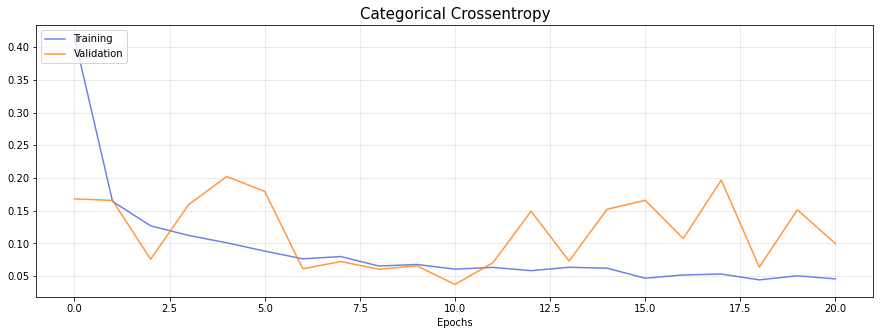

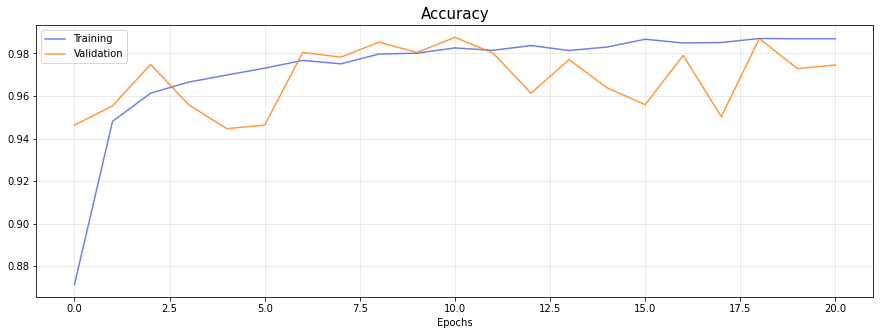

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(standard_history['loss'], label='Training', alpha=.8, color='#4D61E2')
plt.plot(standard_history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy', size=15)
plt.grid(alpha=.3)
plt.xlabel('Epochs')

plt.figure(figsize=(15,5))
plt.plot(standard_history['accuracy'], label='Training', alpha=.8, color='#4D61E2')
plt.plot(standard_history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy',size=15)
plt.grid(alpha=.3)
plt.xlabel('Epochs')

plt.show()